In [1]:
import sklearn as sk
import streamlit as st
import pandas as pd
import numpy as np
import sklearn as sk
import xgboost as xgb
import tensorflow as tf
import keras as ks
import seaborn as sns
import plotly.express as px
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
import warnings
warnings.filterwarnings('ignore')

filepath = "https://raw.githubusercontent.com/lizh1988/portfolio/main/Conc%20strength%20predictor/concrete_data.csv"

df = pd.read_csv(filepath, sep = ',')
df.head()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,concrete_compressive_strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [2]:
df.isnull().sum()

cement                           0
blast_furnace_slag               0
fly_ash                          0
water                            0
superplasticizer                 0
coarse_aggregate                 0
fine_aggregate                   0
age                              0
concrete_compressive_strength    0
dtype: int64

In [3]:
df.rename(columns={'blast_furnace_slag':'slag',
         'fly_ash':'ash', 
         'superplasticizer':'sp',
         'coarse_aggregate':'coarse',
         'concrete_compressive_strength':'strength',
         'fine_aggregate ':'fine'}, inplace=True)
df.head()

,cement,slag,ash,water,sp,coarse,fine,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


<Axes: >

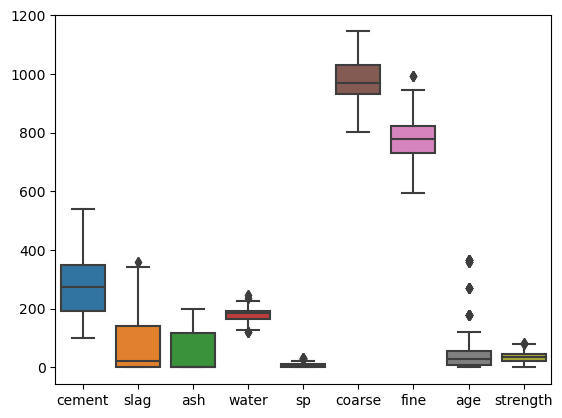

In [4]:
fig = sns.boxplot(data=df)
fig

In [6]:
scaler=sk.preprocessing.StandardScaler()

x = df.drop(['strength'],axis=1)

x_train, x_test, y_train, y_test = sk.model_selection.train_test_split(x ,df['strength'], test_size=0.2, random_state=88)

x_trainsk=scaler.fit_transform(x_train)
x_testsk=scaler.transform(x_test)


y_trainsk=pd.DataFrame(y_train)
y_testsk=pd.DataFrame(y_test)

y_trainsk=scaler.fit_transform(y_trainsk)
y_testsk=scaler.transform(y_testsk)

In [10]:
skreg=sk.linear_model.RidgeCV()
skreg.fit(x_trainsk, y_trainsk)
kfold=sk.model_selection.KFold(n_splits=10, shuffle=True)
scoresk=sk.model_selection.cross_val_score(skreg, x_trainsk, y_trainsk,cv=kfold)
scoresk.mean()

AttributeError: module 'sklearn' has no attribute 'linear_model'

In [ ]:
ypredsk=skreg.predict(x_testsk)
r2=sk.metrics.r2_score(y_testsk,ypredsk)
r2

In [ ]:
#xgb.cv is not used due to excessive runtime

reg=xgb.XGBRegressor()
reg.fit(x_train,y_train)

In [ ]:
kfold=sk.model_selection.KFold(n_splits=10, shuffle=True)

score=sk.model_selection.cross_val_score(reg, x_train, y_train,cv=kfold)
score.mean()

In [ ]:
ypred=reg.predict(x_test)
mse=sk.metrics.mean_squared_error(y_test,ypred)
r2=sk.metrics.r2_score(y_test,ypred)
r2

In [9]:
#parameters = {'device':['cuda'],
#                'nthread':[2], #when use hyperthread, xgboost may become slower
#              'objective':['reg:linear'],
#              'learning_rate': [.03, 0.05, .07], #so called `eta` value
#              'max_depth': [5, 6, 7,8,9],
#              'min_child_weight': [4],
#              'verbosity': [1],
#              'subsample': [0.5, 0.7, 1],
#              'colsample_bytree': [1],
#              'n_estimators': [500]}

space = {
        'device':'cuda',
        'max_depth':hp.choice('max_depth', np.arange(4, 25, 1, dtype=int)),
        'n_estimators':hp.choice('n_estimators', np.arange(100, 10000, 10, dtype=int)),
        'colsample_bytree':hp.quniform('colsample_bytree', 0.5 ,0.9, 0.1),
        'min_child_weight':hp.choice('min_child_weight', np.arange(50, 350, 10, dtype=int)),
        'subsample':hp.quniform('subsample', 0.7, 0.9, 0.1),
        'learning_rate':hp.quniform('eta', 0.05, 0.3, 0.05),
        
        'objective':'reg:squarederror',
        
        'verbosity':0,

        'tree_method':'gpu_hist',
        #'tree_method':'hist',
        'eval_metric': 'rmse',
    }

def score(params):
    model = xgb.XGBRegressor(**params)
    
    model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)],
              verbose=False, early_stopping_rounds=10)
    Y_pred = model.predict(x_test).clip(0, 20)
    score = np.sqrt(sk.metrics.mean_squared_error(y_test, Y_pred))
    print(score)
    return {'loss': score, 'status': STATUS_OK}    
    
def optimize(trials, space):
    
    best = fmin(score, space, algo=tpe.suggest, max_evals=2000)
    return best

trials = Trials()
best_params = optimize(trials, space)

# Return the best parameters
print(space_eval(space, best_params))



#reg_grid=sk.model_selection.GridSearchCV(reg, parameters, scoring='r2', n_jobs=None, refit=True, cv=None, verbose=2, return_train_score=False)

#y_pred1=reg_grid.fit(x_train,y_train)

24.211332298395963                                                                 
 89%|████████▉ | 1781/2000 [38:19<09:33,  2.62s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.28871037752482                                                                  
 89%|████████▉ | 1782/2000 [38:20<07:34,  2.08s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.41811422165621                                                                  
 89%|████████▉ | 1783/2000 [38:21<06:07,  1.70s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.37611463382554                                                                  
 89%|████████▉ | 1784/2000 [38:22<04:58,  1.38s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.308849121934347                                                                 
 89%|████████▉ | 1785/2000 [38:23<04:50,  1.35s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.215176690017554                                                                 
 89%|████████▉ | 1786/2000 [38:25<05:52,  1.65s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.310779600264844                                                                 
 89%|████████▉ | 1787/2000 [38:26<04:59,  1.41s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.398044465798435                                                                 
 89%|████████▉ | 1788/2000 [38:27<04:34,  1.29s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.2050569489171                                                                   
 89%|████████▉ | 1789/2000 [38:29<05:09,  1.47s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.21710296122546                                                                  
 90%|████████▉ | 1790/2000 [38:30<05:00,  1.43s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.426156530147768                                                                 
 90%|████████▉ | 1791/2000 [38:31<04:24,  1.27s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.400389372040355                                                                 
 90%|████████▉ | 1792/2000 [38:32<04:15,  1.23s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.273782084694997                                                                 
 90%|████████▉ | 1793/2000 [38:34<05:03,  1.47s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.211506323429635                                                                 
 90%|████████▉ | 1794/2000 [38:37<05:48,  1.69s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.39951191552455                                                                  
 90%|████████▉ | 1795/2000 [38:38<05:06,  1.50s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.319823625561746                                                                 
 90%|████████▉ | 1796/2000 [38:38<04:22,  1.29s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.210994566883112                                                                 
 90%|████████▉ | 1797/2000 [38:40<04:39,  1.37s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.2050569489171                                                                   
 90%|████████▉ | 1798/2000 [38:42<05:24,  1.61s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.333376596956406                                                                 
 90%|████████▉ | 1799/2000 [38:43<04:39,  1.39s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.207423914863426                                                                 
 90%|█████████ | 1800/2000 [38:46<05:51,  1.76s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.389192736920013                                                                 
 90%|█████████ | 1801/2000 [38:46<04:50,  1.46s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.413656644627146                                                                 
 90%|█████████ | 1802/2000 [38:47<03:58,  1.20s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.205735707730202                                                                 
 90%|█████████ | 1803/2000 [38:49<04:36,  1.41s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.306784807801858                                                                 
 90%|█████████ | 1804/2000 [38:50<04:09,  1.27s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.2050569489171                                                                   
 90%|█████████ | 1805/2000 [38:52<05:03,  1.55s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.420478609159026                                                                 
 90%|█████████ | 1806/2000 [38:53<04:22,  1.35s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.255449436791185                                                                 
 90%|█████████ | 1807/2000 [38:55<04:42,  1.46s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.4075006212727                                                                   
 90%|█████████ | 1808/2000 [38:55<03:59,  1.25s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.304799071856625                                                                 
 90%|█████████ | 1809/2000 [38:56<03:40,  1.15s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.22134854598001                                                                  
 90%|█████████ | 1810/2000 [38:59<04:33,  1.44s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.385537540698984                                                                 
 91%|█████████ | 1811/2000 [39:00<04:08,  1.32s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.2050569489171                                                                   
 91%|█████████ | 1812/2000 [39:02<04:57,  1.58s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.205735707730202                                                                 
 91%|█████████ | 1813/2000 [39:04<05:09,  1.66s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.21063621053498                                                                  
 91%|█████████ | 1814/2000 [39:07<06:36,  2.13s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.22423237734594                                                                  
 91%|█████████ | 1815/2000 [39:08<06:04,  1.97s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.42029083301286                                                                  
 91%|█████████ | 1816/2000 [39:09<04:51,  1.58s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.207861728267638                                                                 
24.42029083301286                                                                  
 91%|█████████ | 1818/2000 [39:13<04:48,  1.58s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.41811422165621                                                                  
24.42029083301286                                                                  
 91%|█████████ | 1820/2000 [39:14<03:07,  1.04s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.245507395535064                                                                 
 91%|█████████ | 1821/2000 [39:15<03:39,  1.22s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.360520396919796                                                                 
 91%|█████████ | 1822/2000 [39:17<03:44,  1.26s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.2050569489171                                                                   
 91%|█████████ | 1823/2000 [39:19<04:44,  1.61s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.2050569489171                                                                   
 91%|█████████ | 1824/2000 [39:21<05:15,  1.79s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.216940941328648                                                                 
 91%|█████████▏| 1825/2000 [39:23<05:01,  1.73s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.313528277538648                                                                 
 91%|█████████▏| 1826/2000 [39:24<04:07,  1.43s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.37611463382554                                                                  
 91%|█████████▏| 1827/2000 [39:24<03:27,  1.20s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.40557441915729                                                                  
 91%|█████████▏| 1828/2000 [39:26<03:25,  1.19s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.2050569489171                                                                   
 91%|█████████▏| 1829/2000 [39:28<04:17,  1.51s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.416866362369987                                                                 
 92%|█████████▏| 1830/2000 [39:29<03:42,  1.31s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.205735707730202                                                                 
 92%|█████████▏| 1831/2000 [39:31<04:11,  1.49s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.310779600264844                                                                 
 92%|█████████▏| 1832/2000 [39:31<03:38,  1.30s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.409463447500798                                                                 
 92%|█████████▏| 1833/2000 [39:32<03:04,  1.11s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.213454447860162                                                                 
 92%|█████████▏| 1834/2000 [39:34<03:55,  1.42s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.29061072050258                                                                  
 92%|█████████▏| 1835/2000 [39:36<04:15,  1.55s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.39951191552455                                                                  
 92%|█████████▏| 1836/2000 [39:37<03:59,  1.46s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.213633485309767                                                                 
 92%|█████████▏| 1837/2000 [39:39<04:18,  1.58s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.319823625561746                                                                 
 92%|█████████▏| 1838/2000 [39:40<03:40,  1.36s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.205990134213476                                                                 
 92%|█████████▏| 1839/2000 [39:42<04:02,  1.51s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.38649585142571                                                                  
 92%|█████████▏| 1840/2000 [39:43<03:46,  1.41s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.303328855013383                                                                 
 92%|█████████▏| 1841/2000 [39:44<03:12,  1.21s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.413656644627146                                                                 
 92%|█████████▏| 1842/2000 [39:45<02:45,  1.05s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.2050569489171                                                                   
 92%|█████████▏| 1843/2000 [39:47<03:41,  1.41s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.207861728267638                                                                 
 92%|█████████▏| 1844/2000 [39:50<05:06,  1.97s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.205735707730202                                                                 
 92%|█████████▏| 1845/2000 [39:52<04:57,  1.92s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.25989942534745                                                                  
 92%|█████████▏| 1846/2000 [39:53<04:23,  1.71s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.420478609159026                                                                 
 92%|█████████▏| 1847/2000 [39:54<03:33,  1.40s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.2974403274163                                                                   
 92%|█████████▏| 1848/2000 [39:56<03:57,  1.56s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.39119733806775                                                                  
 92%|█████████▏| 1849/2000 [39:57<03:37,  1.44s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.22134854598001                                                                  
 92%|█████████▎| 1850/2000 [39:59<04:10,  1.67s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.385537540698984                                                                 
 93%|█████████▎| 1851/2000 [40:00<03:39,  1.47s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.211169372503697                                                                 
 93%|█████████▎| 1852/2000 [40:03<04:41,  1.90s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.4210923183889                                                                   
 93%|█████████▎| 1853/2000 [40:04<03:48,  1.55s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.205735707730202                                                                 
 93%|█████████▎| 1854/2000 [40:05<03:54,  1.61s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.21970271665233                                                                  
 93%|█████████▎| 1855/2000 [40:07<03:37,  1.50s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.304799071856625                                                                 
 93%|█████████▎| 1856/2000 [40:08<03:08,  1.31s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.42029083301286                                                                  
24.42029083301286                                                                  
 93%|█████████▎| 1858/2000 [40:09<02:05,  1.14trial/s, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.208828671924127                                                                 
24.42029083301286                                                                  
 93%|█████████▎| 1860/2000 [40:12<02:51,  1.22s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.2050569489171                                                                   
 93%|█████████▎| 1861/2000 [40:14<03:29,  1.50s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.361165478017632                                                                 
 93%|█████████▎| 1862/2000 [40:15<03:07,  1.36s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.39327785745952                                                                  
 93%|█████████▎| 1863/2000 [40:16<02:45,  1.21s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.205735707730202                                                                 
 93%|█████████▎| 1864/2000 [40:18<03:11,  1.41s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.205735707730202                                                                 
 93%|█████████▎| 1865/2000 [40:20<03:25,  1.52s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.28871037752482                                                                  
 93%|█████████▎| 1866/2000 [40:21<02:58,  1.33s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.21235325452556                                                                  
 93%|█████████▎| 1867/2000 [40:24<04:20,  1.96s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.313528277538648                                                                 
 93%|█████████▎| 1868/2000 [40:25<03:29,  1.59s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.205735707730202                                                                 
 93%|█████████▎| 1869/2000 [40:27<03:39,  1.67s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.2050569489171                                                                   
 94%|█████████▎| 1870/2000 [40:29<03:55,  1.81s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.310779600264844                                                                 
 94%|█████████▎| 1871/2000 [40:30<03:22,  1.57s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.399765366677318                                                                 
 94%|█████████▎| 1872/2000 [40:31<03:07,  1.46s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.409463447500798                                                                 
 94%|█████████▎| 1873/2000 [40:32<02:33,  1.21s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.416866362369987                                                                 
 94%|█████████▎| 1874/2000 [40:32<02:16,  1.09s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.21354072781755                                                                  
 94%|█████████▍| 1875/2000 [40:36<03:32,  1.70s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.2050569489171                                                                   
 94%|█████████▍| 1876/2000 [40:38<03:46,  1.83s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.2050569489171                                                                   
 94%|█████████▍| 1877/2000 [40:40<03:58,  1.94s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.319823625561746                                                                 
 94%|█████████▍| 1878/2000 [40:41<03:17,  1.62s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.40735537187852                                                                  
 94%|█████████▍| 1879/2000 [40:41<02:39,  1.32s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.282790360714657                                                                 
 94%|█████████▍| 1880/2000 [40:43<02:55,  1.46s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.389192736920013                                                                 
 94%|█████████▍| 1881/2000 [40:44<02:30,  1.27s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.221927393773285                                                                 
 94%|█████████▍| 1882/2000 [40:47<03:20,  1.70s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.218414844779648                                                                 
 94%|█████████▍| 1883/2000 [40:49<03:21,  1.73s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.413656644627146                                                                 
 94%|█████████▍| 1884/2000 [40:49<02:42,  1.40s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.333376596956406                                                                 
 94%|█████████▍| 1885/2000 [40:50<02:19,  1.21s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.39389586862594                                                                  
 94%|█████████▍| 1886/2000 [40:51<02:12,  1.16s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.2050569489171                                                                   
 94%|█████████▍| 1887/2000 [40:53<02:48,  1.49s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.42487671864555                                                                  
 94%|█████████▍| 1888/2000 [40:54<02:18,  1.24s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.25989942534745                                                                  
 94%|█████████▍| 1889/2000 [40:55<02:16,  1.23s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.304579561328072                                                                 
 94%|█████████▍| 1890/2000 [40:57<02:26,  1.34s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.304799071856625                                                                 
 95%|█████████▍| 1891/2000 [40:58<02:14,  1.24s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.211169372503697                                                                 
 95%|█████████▍| 1892/2000 [41:01<03:09,  1.76s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.385537540698984                                                                 
 95%|█████████▍| 1893/2000 [41:02<02:50,  1.60s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.205735707730202                                                                 
 95%|█████████▍| 1894/2000 [41:04<03:02,  1.72s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.213854353365665                                                                 
 95%|█████████▍| 1895/2000 [41:07<03:41,  2.11s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.2050569489171                                                                   
 95%|█████████▍| 1896/2000 [41:09<03:42,  2.14s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.22134854598001                                                                  
 95%|█████████▍| 1897/2000 [41:11<03:34,  2.08s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.42029083301286                                                                  
24.42029083301286                                                                  
 95%|█████████▍| 1899/2000 [41:12<02:14,  1.33s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.214184499401405                                                                 
 95%|█████████▌| 1900/2000 [41:14<02:24,  1.45s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.205735707730202                                                                 
 95%|█████████▌| 1901/2000 [41:16<02:27,  1.49s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.41811422165621                                                                  
 95%|█████████▌| 1902/2000 [41:16<02:03,  1.26s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.216940941328648                                                                 
 95%|█████████▌| 1903/2000 [41:18<02:15,  1.40s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.28871037752482                                                                  
 95%|█████████▌| 1904/2000 [41:19<02:01,  1.27s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.42029083301286                                                                  
 95%|█████████▌| 1905/2000 [41:20<01:40,  1.06s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.361165478017632                                                                 
 95%|█████████▌| 1906/2000 [41:21<01:35,  1.01s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.2107059906322                                                                   
 95%|█████████▌| 1907/2000 [41:22<01:56,  1.26s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.37611463382554                                                                  
 95%|█████████▌| 1908/2000 [41:23<01:36,  1.05s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.310779600264844                                                                 
 95%|█████████▌| 1909/2000 [41:24<01:27,  1.04trial/s, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.29117278842961                                                                  
 96%|█████████▌| 1910/2000 [41:25<01:28,  1.02trial/s, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.212251534000753                                                                 
 96%|█████████▌| 1911/2000 [41:26<01:44,  1.17s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.399765366677318                                                                 
 96%|█████████▌| 1912/2000 [41:27<01:41,  1.15s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.2050569489171                                                                   
 96%|█████████▌| 1913/2000 [41:29<01:57,  1.35s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.400389372040355                                                                 
 96%|█████████▌| 1914/2000 [41:30<01:42,  1.19s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.416866362369987                                                                 
 96%|█████████▌| 1915/2000 [41:31<01:24,  1.01trial/s, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.315169192722706                                                                 
 96%|█████████▌| 1916/2000 [41:32<01:22,  1.02trial/s, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.208763807332517                                                                 
 96%|█████████▌| 1917/2000 [41:33<01:40,  1.21s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.39951191552455                                                                  
 96%|█████████▌| 1918/2000 [41:34<01:32,  1.13s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.21006488494347                                                                  
 96%|█████████▌| 1919/2000 [41:36<01:36,  1.19s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.211241993566304                                                                 
 96%|█████████▌| 1920/2000 [41:37<01:39,  1.25s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.333376596956406                                                                 
 96%|█████████▌| 1921/2000 [41:38<01:24,  1.07s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.413656644627146                                                                 
 96%|█████████▌| 1922/2000 [41:38<01:11,  1.09trial/s, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.2050569489171                                                                   
 96%|█████████▌| 1923/2000 [41:40<01:29,  1.17s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.389192736920013                                                                 
 96%|█████████▌| 1924/2000 [41:41<01:16,  1.01s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.208763807332517                                                                 
 96%|█████████▋| 1925/2000 [41:42<01:30,  1.21s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.282790360714657                                                                 
 96%|█████████▋| 1926/2000 [41:44<01:31,  1.23s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.25989942534745                                                                  
 96%|█████████▋| 1927/2000 [41:45<01:28,  1.21s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.288200448264135                                                                 
 96%|█████████▋| 1928/2000 [41:46<01:28,  1.23s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.420478609159026                                                                 
 96%|█████████▋| 1929/2000 [41:47<01:14,  1.04s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.39389586862594                                                                  
 96%|█████████▋| 1930/2000 [41:47<01:09,  1.01trial/s, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.2050569489171                                                                   
 97%|█████████▋| 1931/2000 [41:49<01:24,  1.23s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.205735707730202                                                                 
 97%|█████████▋| 1932/2000 [41:51<01:27,  1.28s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.21709866039788                                                                  
 97%|█████████▋| 1933/2000 [41:52<01:29,  1.34s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.42029083301286                                                                  
 97%|█████████▋| 1934/2000 [41:53<01:12,  1.09s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.385537540698984                                                                 
 97%|█████████▋| 1935/2000 [41:54<01:09,  1.06s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.223721199439094                                                                 
 97%|█████████▋| 1936/2000 [41:55<01:13,  1.15s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.214172775767988                                                                 
 97%|█████████▋| 1937/2000 [41:56<01:16,  1.22s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.2050569489171                                                                   
 97%|█████████▋| 1938/2000 [41:58<01:24,  1.37s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.2050569489171                                                                   
 97%|█████████▋| 1939/2000 [42:00<01:29,  1.46s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.2050569489171                                                                   
 97%|█████████▋| 1940/2000 [42:02<01:35,  1.59s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.2050569489171                                                                   
 97%|█████████▋| 1941/2000 [42:04<01:38,  1.68s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.2050569489171                                                                   
 97%|█████████▋| 1942/2000 [42:05<01:40,  1.73s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.2050569489171                                                                   
 97%|█████████▋| 1943/2000 [42:07<01:42,  1.81s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.2050569489171                                                                   
 97%|█████████▋| 1944/2000 [42:09<01:40,  1.80s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.2050569489171                                                                   
 97%|█████████▋| 1945/2000 [42:11<01:39,  1.80s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.2050569489171                                                                   
 97%|█████████▋| 1946/2000 [42:13<01:41,  1.87s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.2050569489171                                                                   
 97%|█████████▋| 1947/2000 [42:15<01:42,  1.93s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.2050569489171                                                                   
 97%|█████████▋| 1948/2000 [42:17<01:37,  1.87s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.2050569489171                                                                   
 97%|█████████▋| 1949/2000 [42:19<01:35,  1.87s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.2050569489171                                                                   
 98%|█████████▊| 1950/2000 [42:20<01:32,  1.84s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.2050569489171                                                                   
 98%|█████████▊| 1951/2000 [42:22<01:28,  1.80s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.2050569489171                                                                   
 98%|█████████▊| 1952/2000 [42:24<01:25,  1.78s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.2050569489171                                                                   
 98%|█████████▊| 1953/2000 [42:26<01:22,  1.76s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.2050569489171                                                                   
 98%|█████████▊| 1954/2000 [42:27<01:20,  1.74s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.2050569489171                                                                   
 98%|█████████▊| 1955/2000 [42:29<01:19,  1.77s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.2050569489171                                                                   
 98%|█████████▊| 1956/2000 [42:31<01:18,  1.78s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.2050569489171                                                                   
 98%|█████████▊| 1957/2000 [42:33<01:17,  1.80s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.2050569489171                                                                   
 98%|█████████▊| 1958/2000 [42:34<01:13,  1.76s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.2050569489171                                                                   
 98%|█████████▊| 1959/2000 [42:36<01:11,  1.75s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.2050569489171                                                                   
 98%|█████████▊| 1960/2000 [42:38<01:10,  1.77s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.2050569489171                                                                   
 98%|█████████▊| 1961/2000 [42:40<01:08,  1.76s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.304799071856625                                                                 
 98%|█████████▊| 1962/2000 [42:40<00:55,  1.46s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.2050569489171                                                                   
 98%|█████████▊| 1963/2000 [42:42<00:56,  1.53s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.2050569489171                                                                   
 98%|█████████▊| 1964/2000 [42:44<00:58,  1.63s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.2050569489171                                                                   
 98%|█████████▊| 1965/2000 [42:46<00:59,  1.69s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.2050569489171                                                                   
24.42029083301286                                                                  
 98%|█████████▊| 1967/2000 [42:48<00:43,  1.33s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.41811422165621                                                                  
 98%|█████████▊| 1968/2000 [42:49<00:35,  1.11s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.361165478017632                                                                 
 98%|█████████▊| 1969/2000 [42:50<00:32,  1.06s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.28871037752482                                                                  
 98%|█████████▊| 1970/2000 [42:50<00:29,  1.00trial/s, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.313528277538648                                                                 
 99%|█████████▊| 1971/2000 [42:51<00:26,  1.11trial/s, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.215176690017554                                                                 
24.42029083301286                                                                  
 99%|█████████▊| 1973/2000 [42:54<00:28,  1.05s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.2050569489171                                                                   
 99%|█████████▊| 1974/2000 [42:56<00:32,  1.26s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.37611463382554                                                                  
 99%|█████████▉| 1975/2000 [42:56<00:26,  1.08s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.205735707730202                                                                 
 99%|█████████▉| 1976/2000 [42:58<00:30,  1.25s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.205735707730202                                                                 
 99%|█████████▉| 1977/2000 [42:59<00:30,  1.31s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.310779600264844                                                                 
 99%|█████████▉| 1978/2000 [43:00<00:25,  1.15s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.416866362369987                                                                 
 99%|█████████▉| 1979/2000 [43:01<00:20,  1.02trial/s, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.2050569489171                                                                   
 99%|█████████▉| 1980/2000 [43:03<00:26,  1.31s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.2050569489171                                                                   
 99%|█████████▉| 1981/2000 [43:05<00:27,  1.44s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.400389372040355                                                                 
 99%|█████████▉| 1982/2000 [43:05<00:22,  1.23s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.21115045922378                                                                  
 99%|█████████▉| 1983/2000 [43:06<00:20,  1.20s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.413656644627146                                                                 
 99%|█████████▉| 1984/2000 [43:07<00:16,  1.02s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.39951191552455                                                                  
 99%|█████████▉| 1985/2000 [43:08<00:15,  1.01s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.399765366677318                                                                 
 99%|█████████▉| 1986/2000 [43:09<00:14,  1.04s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.319823625561746                                                                 
 99%|█████████▉| 1987/2000 [43:10<00:12,  1.04trial/s, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.2050569489171                                                                   
 99%|█████████▉| 1988/2000 [43:12<00:15,  1.33s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.2050569489171                                                                   
 99%|█████████▉| 1989/2000 [43:14<00:16,  1.54s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.210658623860507                                                                 
100%|█████████▉| 1990/2000 [43:16<00:17,  1.76s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.333376596956406                                                                 
100%|█████████▉| 1991/2000 [43:17<00:13,  1.45s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.273782084694997                                                                 
100%|█████████▉| 1992/2000 [43:19<00:12,  1.57s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.389192736920013                                                                 
100%|█████████▉| 1993/2000 [43:20<00:09,  1.32s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.25989942534745                                                                  
100%|█████████▉| 1994/2000 [43:21<00:07,  1.31s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.205735707730202                                                                 
100%|█████████▉| 1995/2000 [43:23<00:07,  1.40s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.420478609159026                                                                 
100%|█████████▉| 1996/2000 [43:23<00:04,  1.17s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.306784807801858                                                                 
100%|█████████▉| 1997/2000 [43:24<00:03,  1.07s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.39389586862594                                                                  
100%|█████████▉| 1998/2000 [43:25<00:02,  1.05s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.20835841157486                                                                  
100%|█████████▉| 1999/2000 [43:27<00:01,  1.22s/trial, best loss: 24.2050569489171]

c:\Users\lizhi\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



24.385537540698984                                                                 
100%|██████████| 2000/2000 [43:28<00:00,  1.30s/trial, best loss: 24.2050569489171]
{'colsample_bytree': 0.9, 'device': 'cuda', 'eval_metric': 'rmse', 'learning_rate': 0.15000000000000002, 'max_depth': 6, 'min_child_weight': 50, 'n_estimators': 8990, 'objective': 'reg:squarederror', 'subsample': 0.9, 'tree_method': 'gpu_hist', 'verbosity': 0}


In [10]:
#score=sk.model_selection.cross_val_score(reg_grid, x_train, y_train,cv=kfold)
#score.mean()

optparam=(space_eval(space, best_params))
#for i in space_eval(space, best_params):
#    print (k)
regopt=xgb.XGBRegressor(**optparam)
print(regopt)
#print(space)
#print(**best_params)
regopt.fit(x_train,y_train)
ypred=regopt.predict(x_test)
mse=sk.metrics.mean_squared_error(y_test,ypred)
r2=sk.metrics.r2_score(y_test,ypred)
print(r2)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.15000000000000002,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=50, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=8990, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
0.9425516372132591


In [11]:
mse

17.686074761650104